In [2]:

import numpy as np
import scipy as sp
from astropy.io import fits as pyfits
from astropy.table import Table
import desispec.io
from desispec.interpolation import resample_flux
#from desitarget.targetmask import desi_mask
#import sys
import os

import scipy.optimize as scpo
import matplotlib.pyplot as plt

import fitsio

# Desi catalog test
import glob
from itertools import compress
import healpy

import empca



In [2]:
####  Catalog cutter eBoss
def cat_cutter_eBoss( Nnew ):
   file = '/work3/desi_lya/data/eBOSS/dr15_all/DR14Q_v4_4.fits' # Add here the filename, include the full path if necesary
   output = '/home/sfbeltranv/respaldo/DR14_mini/DR14Q_v4_4m.fits'
   output = '/home/sfbeltranv/respaldo/DR14_mini/picca150000.fits'
   #file = '/work3/desi_lya/mocks_quick/london/v9.0.0_small/zcat_drq.fits'
   #output = '/home/sfbeltranv/respaldo/DR14_mini/zcatdrq_m.fits'

   hdul = pyfits.open(file)
   data = hdul[1].data
   hdul.info()

   # Nor: Origina size, Nnew: new size for the catalog (in overall items)
   Nor = len(data)
   print(Nor)
   #Nnew = 10000

   # Random Mask of Nnew items from the Nor items of the orignal catalog
   w = np.random.choice(Nor,Nnew,replace=False)

   if os.path.exists(output):
     os.remove(output)

   # Mask set in the catalog
   hdul[1].data = data[w]
   hdul.writeto(output)   # change name to the desired one.
   hdul.close()
   print('\n\nDone writing.\n')


   hdul = pyfits.open( output )
   data = hdul[1].data
   hdul.info()
   hdul.close() 
   print('\nDone with final size= ', len(data) )

#cat_cutter_eBoss(10000)


In [3]:
####  Catalog cutter Desi
def cat_cutter_Desi( Nnew ):
   

   file = '/work3/desi_lya/mocks_quick/london/v9.0.0_small/zcat.fits' # Add here the filename, include the full path if necesary
   output = '/home/sfbeltranv/respaldo/DR14_mini/zcat_m.fits'
   output = '/work/sfbeltranv/lya-blinding/oneCat.fits'

   hdul = pyfits.open(file)
   data = hdul[1].data
   hdul.info()

   # Nor: Origina size, Nnew: new size for the catalog (in overall items)
   Nor = len(data)
   #Nnew = 10000

   # Random Mask of Nnew items from the Nor items of the orignal catalog
   w = np.random.choice(Nor,Nnew,replace=False)

   if os.path.exists(output):
     os.remove(output)

   # Mask set in the catalog
   hdul[1].data = data[w]
   hdul.writeto(output)   # change name to the desired one.
   hdul.close()
   print('\n\nDone writing.\n')


   hdul = pyfits.open( output )
   data = hdul[1].data
   hdul.info()
   hdul.close() 
   print('\nDone with final size= ', len(data) )
      
#cat_cutter_Desi( 4 )   

In [4]:
def normalizeSpec( x, y, xmin, xmax, normfactor = 6):
   
   xrange =  (x > xmin ) & (x < xmax ) 
   
   return y / ( np.sum(y[xrange]) * (x[1]-x[0]) ) * normfactor

def load_eBoss(path_drq, path_spec, zmin, zmax, lmin, lmax):
   # eBoss Catalog load
   catalog = Table.read(path_drq)
   
   w = (catalog['THING_ID']>0) & (catalog['Z'] > zmin ) & (catalog['Z']< zmax ) & (catalog['RA']!=catalog['DEC'])& (catalog['RA']>0) & (catalog['DEC']>0)
   reduced_cat = catalog[w]
   reduced_cat = reduced_cat.group_by('PLATE')

   nest = True
   in_nside = 16
   
   thing_id = reduced_cat['THING_ID']
   fiberid = reduced_cat['FIBERID']
   plate = reduced_cat['PLATE']
   zqso = reduced_cat['Z']
   DEC = reduced_cat['DEC']* np.pi/180
   RA = reduced_cat['RA']* np.pi/180

   plate_list=[]
   for p,m in zip(reduced_cat['PLATE'],reduced_cat['MJD']):
        plate_list.append(str(p)+'/spPlate-'+str(p)+'-'+str(m)+'.fits')
   plate_list=np.unique(plate_list)

    #thisplate=plate_list[0].split("/")[1]  # Location
    #thisplate=plate_list[0].split("/")[0]  # Plate Number
   print('Found '+ str(  np.sum(w) ) + ' QSO spec. in ' +str(len(plate_list))+ ' files of catalog: '+ path_drq )
    
   spectra = []
   QSOloc = []
   ## begin for test
   for nplate in range ( 0, len(plate_list) ):      # len(plate_list)
      plate1=pyfits.open( path_spec+'/'+plate_list[nplate].split("/")[1] )
      thisplate=plate_list[nplate].split("/")[0]  # Plate Number

      wp = plate == int( thisplate )
      ids_=fiberid[wp]
      tids_=thing_id[wp]
      zqso_=zqso[wp]
      DEC_ = DEC[wp]
      RA_ = RA[wp]
      
      nqsoPlate_= ids_.shape[0]
      print( str(nplate) + ': Loading '+ str(nqsoPlate_) +' QSO spec. from plate: '+ plate_list[nplate].split("/")[1] )
      # Reading data from plate
      plugmap = plate1['PLUGMAP'].data
      # Searching for fiber of qso in data
      wp = np.in1d(plugmap['FIBERID'],ids_)
      # Applying mask to select only QSO
      small_plugmap = plugmap[wp]

      #Get the spectra
      flux=plate1[0].data
      #Get the weight
      ivar=plate1[1].data

      #Get the wavelenght
      pltheader=plate1[0].header
      coeff0=pltheader['COEFF0']
      coeff1=pltheader['COEFF1']
      logwave=coeff0+coeff1*np.arange(flux.shape[1])
      for i in range(0,nqsoPlate_):
            w_ = (10**logwave)/(1+zqso_[i])
            w_crop = ( w_ >= lmin ) & ( w_ <= lmax )
            w_ = w_[w_crop]
            flx = flux[ids_[i]-1][w_crop]
            ivr = ivar[ids_[i]-1][w_crop]
            flx = normalizeSpec( w_, flx, 1300, 1500)
            
            heal_pix = healpy.ang2pix(in_nside, sp.pi/2.-DEC_[i], RA_[i], nest)
            
            QSOloc.append( np.hstack(( zqso_[i], DEC_[i], RA_[i], tids_[i]  )) )
            s=np.vstack( ( w_.conj().transpose(), flx.conj().transpose(), ivr.conj().transpose() ) )
            spectra.append( s )
   print('Reading done.')   
   return QSOloc, spectra


#####################################
# Load QSO from plates     eBoss
### Parameters
path_spec      = '/work3/desi_lya/data/eBOSS/dr15_all/spplates'
path_drq       = '/home/sfbeltranv/respaldo/DR14_mini/picca5000.fits'

# for line correction (later)
#path_lines     = '/work3/desi_lya/data/eBOSS/dr12_all/dr16-line-sky-mask.txt'

zmin = 2
zmax = 4

lmin = 1040
lmax = 1600

QSOloc_eBoss, spectra_eBoss = load_eBoss(path_drq, path_spec, zmin, zmax, lmin, lmax)



Found 1899 QSO spec. in 1313 files of catalog: /home/sfbeltranv/respaldo/DR14_mini/picca5000.fits
0: Loading 1 QSO spec. from plate: spPlate-3586-55181.fits
1: Loading 1 QSO spec. from plate: spPlate-3606-55182.fits
2: Loading 1 QSO spec. from plate: spPlate-3615-55179.fits
3: Loading 1 QSO spec. from plate: spPlate-3651-55247.fits
4: Loading 1 QSO spec. from plate: spPlate-3655-55240.fits
5: Loading 1 QSO spec. from plate: spPlate-3656-55241.fits
6: Loading 1 QSO spec. from plate: spPlate-3659-55181.fits
7: Loading 3 QSO spec. from plate: spPlate-3670-55480.fits
8: Loading 1 QSO spec. from plate: spPlate-3673-55178.fits
9: Loading 1 QSO spec. from plate: spPlate-3678-55208.fits
10: Loading 1 QSO spec. from plate: spPlate-3679-55209.fits
11: Loading 2 QSO spec. from plate: spPlate-3681-55243.fits
12: Loading 1 QSO spec. from plate: spPlate-3682-55244.fits
13: Loading 1 QSO spec. from plate: spPlate-3689-55180.fits
14: Loading 1 QSO spec. from plate: spPlate-3693-55208.fits
15: Loading 

139: Loading 1 QSO spec. from plate: spPlate-4204-55470.fits
140: Loading 1 QSO spec. from plate: spPlate-4205-55454.fits
141: Loading 1 QSO spec. from plate: spPlate-4212-55447.fits
142: Loading 1 QSO spec. from plate: spPlate-4213-55449.fits
143: Loading 1 QSO spec. from plate: spPlate-4217-55478.fits
144: Loading 1 QSO spec. from plate: spPlate-4222-55444.fits
145: Loading 2 QSO spec. from plate: spPlate-4223-55451.fits
146: Loading 1 QSO spec. from plate: spPlate-4227-55481.fits
147: Loading 1 QSO spec. from plate: spPlate-4234-55478.fits
148: Loading 2 QSO spec. from plate: spPlate-4235-55451.fits
149: Loading 1 QSO spec. from plate: spPlate-4238-55455.fits
150: Loading 2 QSO spec. from plate: spPlate-4239-55458.fits
151: Loading 1 QSO spec. from plate: spPlate-4240-55455.fits
152: Loading 1 QSO spec. from plate: spPlate-4242-55476.fits
153: Loading 1 QSO spec. from plate: spPlate-4256-55477.fits
154: Loading 1 QSO spec. from plate: spPlate-4257-55480.fits
155: Loading 1 QSO spec.

276: Loading 2 QSO spec. from plate: spPlate-4640-55927.fits
277: Loading 4 QSO spec. from plate: spPlate-4646-55622.fits
278: Loading 1 QSO spec. from plate: spPlate-4650-55648.fits
279: Loading 1 QSO spec. from plate: spPlate-4652-55672.fits
280: Loading 2 QSO spec. from plate: spPlate-4654-55659.fits
281: Loading 1 QSO spec. from plate: spPlate-4655-55620.fits
282: Loading 1 QSO spec. from plate: spPlate-4657-55591.fits
283: Loading 1 QSO spec. from plate: spPlate-4659-55587.fits
284: Loading 4 QSO spec. from plate: spPlate-4660-56191.fits
285: Loading 2 QSO spec. from plate: spPlate-4661-55614.fits
286: Loading 1 QSO spec. from plate: spPlate-4663-55893.fits
287: Loading 1 QSO spec. from plate: spPlate-4665-56209.fits
288: Loading 3 QSO spec. from plate: spPlate-4667-55868.fits
289: Loading 4 QSO spec. from plate: spPlate-4668-56211.fits
290: Loading 1 QSO spec. from plate: spPlate-4669-55831.fits
291: Loading 1 QSO spec. from plate: spPlate-4688-56008.fits
292: Loading 2 QSO spec.

414: Loading 1 QSO spec. from plate: spPlate-5025-55836.fits
415: Loading 1 QSO spec. from plate: spPlate-5027-56218.fits
416: Loading 1 QSO spec. from plate: spPlate-5029-55750.fits
417: Loading 1 QSO spec. from plate: spPlate-5031-56209.fits
418: Loading 2 QSO spec. from plate: spPlate-5033-56244.fits
419: Loading 1 QSO spec. from plate: spPlate-5035-55829.fits
420: Loading 4 QSO spec. from plate: spPlate-5036-55751.fits
421: Loading 1 QSO spec. from plate: spPlate-5038-56235.fits
422: Loading 1 QSO spec. from plate: spPlate-5042-55856.fits
423: Loading 1 QSO spec. from plate: spPlate-5043-56187.fits
424: Loading 1 QSO spec. from plate: spPlate-5044-56186.fits
425: Loading 1 QSO spec. from plate: spPlate-5045-56181.fits
426: Loading 2 QSO spec. from plate: spPlate-5046-56243.fits
427: Loading 2 QSO spec. from plate: spPlate-5049-56103.fits
428: Loading 1 QSO spec. from plate: spPlate-5055-55889.fits
429: Loading 1 QSO spec. from plate: spPlate-5058-56208.fits
430: Loading 1 QSO spec.

550: Loading 2 QSO spec. from plate: spPlate-5409-55957.fits
551: Loading 1 QSO spec. from plate: spPlate-5410-56016.fits
552: Loading 1 QSO spec. from plate: spPlate-5411-55953.fits
553: Loading 1 QSO spec. from plate: spPlate-5412-55981.fits
554: Loading 1 QSO spec. from plate: spPlate-5414-56014.fits
555: Loading 1 QSO spec. from plate: spPlate-5418-56037.fits
556: Loading 3 QSO spec. from plate: spPlate-5421-55980.fits
557: Loading 1 QSO spec. from plate: spPlate-5422-55986.fits
558: Loading 2 QSO spec. from plate: spPlate-5423-55958.fits
559: Loading 1 QSO spec. from plate: spPlate-5427-56001.fits
560: Loading 2 QSO spec. from plate: spPlate-5431-56011.fits
561: Loading 1 QSO spec. from plate: spPlate-5432-56008.fits
562: Loading 1 QSO spec. from plate: spPlate-5434-56033.fits
563: Loading 3 QSO spec. from plate: spPlate-5435-55982.fits
564: Loading 1 QSO spec. from plate: spPlate-5436-56015.fits
565: Loading 1 QSO spec. from plate: spPlate-5437-55973.fits
566: Loading 1 QSO spec.

685: Loading 1 QSO spec. from plate: spPlate-5953-56092.fits
686: Loading 1 QSO spec. from plate: spPlate-5954-56462.fits
687: Loading 2 QSO spec. from plate: spPlate-5957-56210.fits
688: Loading 1 QSO spec. from plate: spPlate-5959-56214.fits
689: Loading 1 QSO spec. from plate: spPlate-5966-56101.fits
690: Loading 2 QSO spec. from plate: spPlate-5968-56356.fits
691: Loading 1 QSO spec. from plate: spPlate-5969-56069.fits
692: Loading 1 QSO spec. from plate: spPlate-5970-56072.fits
693: Loading 1 QSO spec. from plate: spPlate-5971-56064.fits
694: Loading 1 QSO spec. from plate: spPlate-5972-56334.fits
695: Loading 1 QSO spec. from plate: spPlate-5974-56314.fits
696: Loading 3 QSO spec. from plate: spPlate-5975-56334.fits
697: Loading 1 QSO spec. from plate: spPlate-5976-56356.fits
698: Loading 3 QSO spec. from plate: spPlate-5977-56098.fits
699: Loading 1 QSO spec. from plate: spPlate-5978-56073.fits
700: Loading 1 QSO spec. from plate: spPlate-5979-56329.fits
701: Loading 2 QSO spec.

/home/sfbeltranv/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


789: Loading 1 QSO spec. from plate: spPlate-6197-56191.fits
790: Loading 1 QSO spec. from plate: spPlate-6202-56266.fits
791: Loading 1 QSO spec. from plate: spPlate-6203-56266.fits
792: Loading 2 QSO spec. from plate: spPlate-6205-56187.fits
793: Loading 2 QSO spec. from plate: spPlate-6206-56245.fits
794: Loading 1 QSO spec. from plate: spPlate-6207-56239.fits
795: Loading 1 QSO spec. from plate: spPlate-6252-56248.fits
796: Loading 1 QSO spec. from plate: spPlate-6253-56574.fits
797: Loading 1 QSO spec. from plate: spPlate-6256-56323.fits
798: Loading 1 QSO spec. from plate: spPlate-6257-56274.fits
799: Loading 1 QSO spec. from plate: spPlate-6259-56565.fits
800: Loading 1 QSO spec. from plate: spPlate-6260-56568.fits
801: Loading 1 QSO spec. from plate: spPlate-6263-56279.fits
802: Loading 1 QSO spec. from plate: spPlate-6265-56248.fits
803: Loading 2 QSO spec. from plate: spPlate-6266-56223.fits
804: Loading 1 QSO spec. from plate: spPlate-6268-56245.fits
805: Loading 1 QSO spec.

930: Loading 2 QSO spec. from plate: spPlate-6647-56390.fits
931: Loading 2 QSO spec. from plate: spPlate-6648-56383.fits
932: Loading 1 QSO spec. from plate: spPlate-6657-56366.fits
933: Loading 3 QSO spec. from plate: spPlate-6658-56606.fits
934: Loading 1 QSO spec. from plate: spPlate-6664-56383.fits
935: Loading 1 QSO spec. from plate: spPlate-6665-56390.fits
936: Loading 1 QSO spec. from plate: spPlate-6674-56416.fits
937: Loading 1 QSO spec. from plate: spPlate-6675-56415.fits
938: Loading 2 QSO spec. from plate: spPlate-6677-56385.fits
939: Loading 1 QSO spec. from plate: spPlate-6680-56420.fits
940: Loading 1 QSO spec. from plate: spPlate-6681-56419.fits
941: Loading 4 QSO spec. from plate: spPlate-6683-56416.fits
942: Loading 1 QSO spec. from plate: spPlate-6684-56412.fits
943: Loading 1 QSO spec. from plate: spPlate-6685-56412.fits
944: Loading 3 QSO spec. from plate: spPlate-6689-56396.fits
945: Loading 1 QSO spec. from plate: spPlate-6694-56386.fits
946: Loading 1 QSO spec.

1064: Loading 2 QSO spec. from plate: spPlate-7278-57041.fits
1065: Loading 1 QSO spec. from plate: spPlate-7279-57071.fits
1066: Loading 1 QSO spec. from plate: spPlate-7280-56709.fits
1067: Loading 2 QSO spec. from plate: spPlate-7281-57007.fits
1068: Loading 2 QSO spec. from plate: spPlate-7282-56660.fits
1069: Loading 3 QSO spec. from plate: spPlate-7285-56991.fits
1070: Loading 1 QSO spec. from plate: spPlate-7286-57096.fits
1071: Loading 1 QSO spec. from plate: spPlate-7289-57039.fits
1072: Loading 1 QSO spec. from plate: spPlate-7290-57073.fits
1073: Loading 2 QSO spec. from plate: spPlate-7291-56992.fits
1074: Loading 1 QSO spec. from plate: spPlate-7293-56741.fits
1075: Loading 1 QSO spec. from plate: spPlate-7294-56739.fits
1076: Loading 1 QSO spec. from plate: spPlate-7296-57046.fits
1077: Loading 1 QSO spec. from plate: spPlate-7298-56661.fits
1078: Loading 2 QSO spec. from plate: spPlate-7304-56745.fits
1079: Loading 1 QSO spec. from plate: spPlate-7305-56991.fits
1080: Lo

1203: Loading 2 QSO spec. from plate: spPlate-7866-57002.fits
1204: Loading 2 QSO spec. from plate: spPlate-7870-57016.fits
1205: Loading 1 QSO spec. from plate: spPlate-7872-57279.fits
1206: Loading 3 QSO spec. from plate: spPlate-8054-57194.fits
1207: Loading 5 QSO spec. from plate: spPlate-8055-57187.fits
1208: Loading 1 QSO spec. from plate: spPlate-8056-57186.fits
1209: Loading 1 QSO spec. from plate: spPlate-8068-57185.fits
1210: Loading 1 QSO spec. from plate: spPlate-8164-57127.fits
1211: Loading 1 QSO spec. from plate: spPlate-8165-57374.fits
1212: Loading 1 QSO spec. from plate: spPlate-8166-57130.fits
1213: Loading 1 QSO spec. from plate: spPlate-8167-57071.fits
1214: Loading 1 QSO spec. from plate: spPlate-8170-57131.fits
1215: Loading 1 QSO spec. from plate: spPlate-8171-57135.fits
1216: Loading 3 QSO spec. from plate: spPlate-8172-57423.fits
1217: Loading 1 QSO spec. from plate: spPlate-8173-57375.fits
1218: Loading 1 QSO spec. from plate: spPlate-8174-57374.fits
1219: Lo

In [69]:
def chi2( alpha, *args ):
   a,b = alpha
   w,flux,ivar = args
   return np.sum( (( flux - (a*w+b) )**2 ) * ivar )

In [70]:
#####################################
# Load QSO from plates     Desi
### Parameters
path_spec      = '/work3/desi_lya/mocks_quick/london/v9.0.0_small/spectra-16'
path_zcat      = '/home/sfbeltranv/respaldo/DR14_mini/zcat_m.fits'

# for line correction (later)
#path_lines     = '/work3/desi_lya/data/eBOSS/dr12_all/dr16-line-sky-mask.txt'

zmin = 2
zmax = 4

catalog = Table.read(path_zcat)


file = '/work3/desi_lya/mocks_quick/london/v9.0.0_small/spectra-16/10/1005/spectra-16-1005.fits' 
spec = Table.read( file )
#spec

h = pyfits.open( file )

h[0].header[4]

spectra_base= desispec.io.read_spectra( file )

spectra_base.__dict__
spectra_base.fibermap.__dict__
spectra_base.fibermap['TARGETID']

#spectra_base.meta
#spectra_base.meta['HPXPIXEL']

catalog['TARGETID']

60168679
80165406
42417
70133197
60182452
50255050
20110721
20061421
80355876
30227575
80319031


In [6]:
def splitID(fi_str):
   fi_str= fi_str.split("spectra-16-")[1]
   return fi_str.split(".fits")[0]


def load_Desi(path_zcat, path_spec, zmin, zmax, lmin, lmax):
   # Desi Catalog load, beginning of function
   catalog = Table.read(path_zcat)
   qso_string = catalog['SPECTYPE'][0]
   
   #w = (catalog['SPECTYPE']==qso_string ) & (catalog['Z'] > zmin ) & (catalog['Z']< zmax ) & (catalog['RA']!=catalog['DEC'])& (catalog['RA']>0) & (catalog['DEC']>0)
   w = (catalog['SPECTYPE']==qso_string ) & (catalog['Z'] >= zmin ) & (catalog['Z'] <= zmax ) 
   reduced_cat = catalog[w]

   nest = True
   in_nside = 16

   targetid = reduced_cat['TARGETID']
   zqso = reduced_cat['Z']
   DEC = reduced_cat['DEC'] * np.pi/180
   RA = reduced_cat['RA'] * np.pi/180

   heal_pix = healpy.ang2pix(in_nside, sp.pi/2.-DEC, RA, nest)
   plate_list = np.unique(heal_pix)
   
   print( len( reduced_cat ) )
   print('healpix len: ', len(plate_list), 'healpix values: ',  plate_list )
   fi = glob.glob(path_spec+'/*/*/spectra*.fits*')
   print('Found', len(fi), 'spectra files.\n')
   fi_fix = []
   for i in range( 0, len(fi)):
       fi_fix.append( splitID(fi[i]) )

   fi_fix =  np.array( list(map(int, fi_fix)) ) 
   
   print('Found '+ str(  np.sum(w) ) + ' QSO spec. in ' + str( len(plate_list) ) + ' files.' )
   
   spectra = []
   QSOloc = []
   
   ## begin for test
   for nplate in range( 0, len(plate_list) ):      # len(plate_list)
      thisplate = plate_list[ nplate ]
      wp = heal_pix == int( thisplate )
      
      ids_ = targetid[wp]
      zqso_= zqso[wp]
      DEC_ = DEC[wp]
      RA_ = RA[wp]
      heal_pix_ = heal_pix[wp]
      
      # heal_pix: From healpy.ang2pix
      # plate_list: Unique from healpy.ang2pix \n
      # fi_fix: Plate id from directory list
      # fi: All files from glob
      nqsoPlate_= ids_.shape[0]
      # print( str(nplate) + ': Loading '+ str(nqsoPlate_) +' QSO spec. from file: '+ [] )      
      wpf = fi_fix == thisplate
      index = wpf * np.arange( len(fi_fix) )
      index = np.squeeze( index[wpf] )
      
      
      #print( thisplate,  nqsoPlate_ , len(fi_fix) )
      
      # print( thisplate, fi_fix[index], nqsoPlate_, fi[index] )
      print( str(nplate) + ': Loading '+ str(nqsoPlate_) +' QSO spec. from file: '+  str(thisplate) )
      
      spectra_base = desispec.io.read_spectra( fi[index] )   
      
      joint1 = np.in1d( spectra_base.wave['b'], spectra_base.wave['r'])
      joint2 = np.in1d( spectra_base.wave['r'], spectra_base.wave['b'])
            
      ll = np.concatenate( ( spectra_base.wave['b'][np.invert(joint1)] , spectra_base.wave['r'] ) )
      
      for i in range(0,nqsoPlate_):
         
         index = np.where( np.array( spectra_base.fibermap['TARGETID'].data ) == ids_.data[i] )
         index = np.squeeze(index)
         
         w_ = (ll)/(1+zqso_[ i ])
         w_crop = ( w_ >= lmin ) & ( w_ <= lmax )
         w_ = w_[w_crop] 
         
         intersec = ( spectra_base.ivar['b'][ index ][joint1]*spectra_base.flux['b'][ index ][joint1] + spectra_base.ivar['r'][ index ][joint2]*spectra_base.flux['r'][ index ][joint2] )
         intersec = intersec /( spectra_base.ivar['b'][ index ][joint1] + spectra_base.ivar['r'][ index ][joint2] )

         flx = np.concatenate( ( spectra_base.flux['b'][ index ][np.invert(joint1)], intersec, \
               spectra_base.flux['r'][ index ][np.invert(joint2)] ) )
         flx = flx[w_crop]
         
         intersec = ( spectra_base.ivar['b'][ index ][joint1] + spectra_base.ivar['r'][ index ][joint2] ) 
         ivr = np.concatenate( ( spectra_base.ivar['b'][ index ][np.invert(joint1)], intersec, \
               spectra_base.ivar['r'][ index ][np.invert(joint2)] ) )
         ivr = ivr[w_crop]
         
         flx = normalizeSpec( w_, flx, 1300, 1500)
         #flx = normalizeSpec( w_, flx, 1300, 1500)

         
         QSOloc.append( np.hstack(( zqso_[i], DEC_[i], RA_[i], ids_[i] )) ) 
         s=np.vstack( ( w_.conj().transpose(), flx.conj().transpose(), ivr.conj().transpose() ) )
         spectra.append( s )
   
   print('Reading done.')
   return QSOloc, spectra


path_zcat = '/home/sfbeltranv/respaldo/DR14_mini/zcat_m.fits' 
path_spec = '/work3/desi_lya/mocks_quick/london/v9.0.0_small/spectra-16'

zmin = 2.
zmax = 4.288461538461538

lmin = 1040
lmax = 1600

QSOloc_Desi, spectra_Desi = load_Desi(path_zcat, path_spec, zmin, zmax, lmin, lmax)



7624
healpix len:  164 healpix values:  DEC 
----
   0
   1
   2
   3
   8
   9
  10
  11
  12
  14
 ...
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
Length = 164 rows
Found 167 spectra files.

Found 7624 QSO spec. in 164 files.
0: Loading 71 QSO spec. from file: 0
1: Loading 24 QSO spec. from file: 1
2: Loading 60 QSO spec. from file: 2
3: Loading 14 QSO spec. from file: 3
4: Loading 50 QSO spec. from file: 8
5: Loading 26 QSO spec. from file: 9
6: Loading 51 QSO spec. from file: 10
7: Loading 52 QSO spec. from file: 11
8: Loading 1 QSO spec. from file: 12
9: Loading 30 QSO spec. from file: 14
10: Loading 60 QSO spec. from file: 32
11: Loading 51 QSO spec. from file: 33
12: Loading 49 QSO spec. from file: 34
13: Loading 41 QSO spec. from file: 35
14: Loading 53 QSO spec. from file: 36
15: Loading 27 QSO spec. from file: 37
16: Loading 55 QSO spec. from file: 38
17: Loading 49 QSO spec. from file: 39
18: Loading 43 QSO spec. from file: 40
19: Loading 41 QSO spec. from file: 4

(1050, 1600)

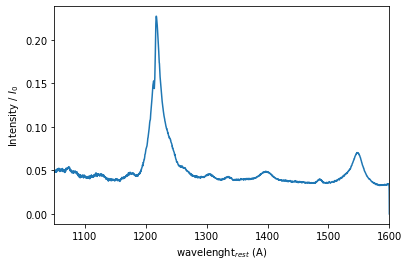

In [71]:
if 0:   #  Save / Load continuum with 10k obj catalog.
   np.save('wave',mwave11)
   np.save('meanf',mmean11)
   np.save('meanstd',mstd11)
else:
   mwave11 = np.load('wave.npy')
   mmean11 = np.load('meanf.npy')
   mstd11 = np.load('meanstd.npy')

plt.plot(mwave11, mmean11)
plt.xlabel(r'wavelenght$_{rest}$ (A)')
plt.ylabel(r'Intensity / $I_0$')
plt.xlim(1050,1600)

#plt.plot(mwave11, mstd11)                    




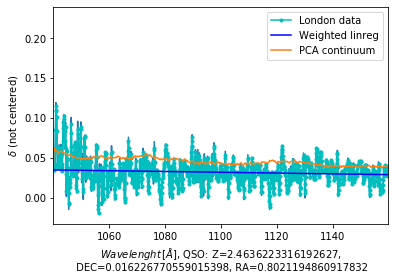

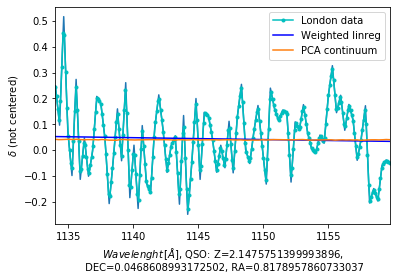

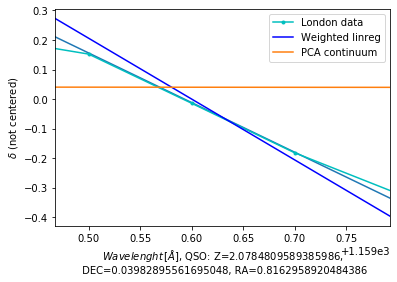

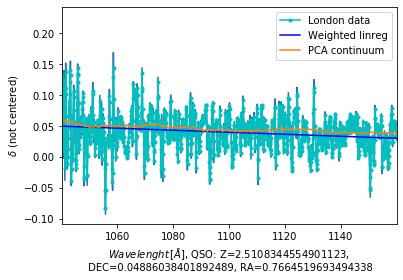

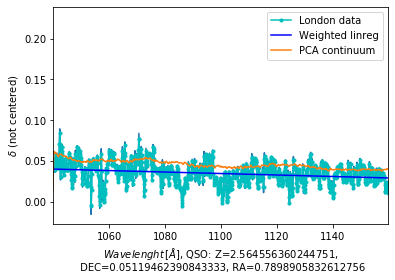

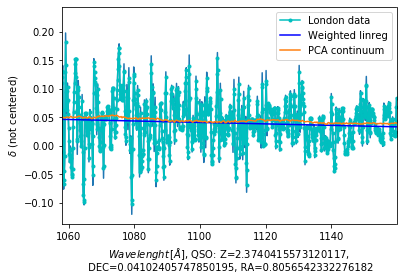

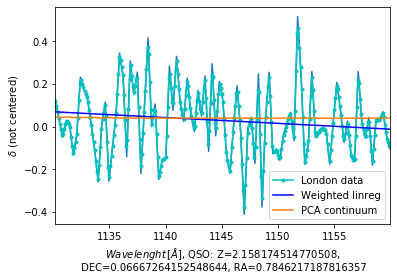

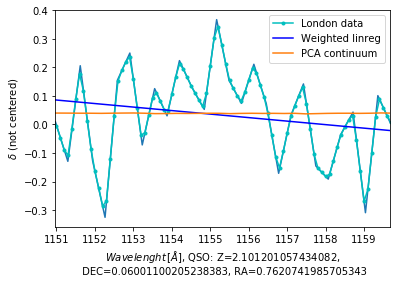

In [72]:
#### One QSO ploting example


spectra = spectra_Desi
QSOloc = QSOloc_Desi
wwave = np.arange( lmin, lmax, .1) 


specSize = len(spectra)
specSize = 10

pcafluxm  = np.zeros(( specSize, wwave.size))
pcaivarm  = np.zeros(( specSize, wwave.size))

for nspectra in range( 0, specSize):
   # nspectra = 100
   s = spectra[ nspectra ]
   z, dec, ra, id_ = QSOloc[ nspectra ]
   w_ = s[0]
   wmask = (w_>1040) & ( w_<1160)
   
   w_ = w_[wmask]
   if len(w_) > 0:
      flux_ = s[1]
      ivar_ = s[2]

      flux_ = flux_[wmask]
      ivar_ = ivar_[wmask]


      param = scpo.minimize(chi2, (1,1), args=( w_, flux_, ivar_) ); #COBYLA
      delta_ = flux_ / (param.x[0]*w_+param.x[1])  -  1



      pcafluxm[nspectra], pcaivarm[nspectra] = resample_flux( wwave, w_, flux_, ivar_ ) # interpolation

      plt.plot(w_,flux_)
      plt.plot(wwave, pcafluxm[nspectra], 'c.-',label = 'London data' )

      plt.plot(w_, param.x[0]*w_+param.x[1],'b', label = 'Weighted linreg'  )
      plt.plot(mwave11, mmean11, label='PCA continuum')
      plt.xlim(np.min(w_),np.max(w_))
      plt.legend()

   #else:
   #   np.delete( spectra[nspectra] )

      plt.xlabel( r'$Wavelenght\, [\AA]$, QSO: Z=' + str( z) + ',\n DEC=' + str( dec) +', RA=' + str( ra)  )
      plt.ylabel( r'$\delta$ (not centered)' )
      plt.show()


In [9]:
# def comovil distance calculation

z_ = np.linspace(0, 5., 1000)
r_ = np.zeros(1000)

omega_m = 0.31
omega_L = 0.69
cH0 = 3000

Hz = np.sqrt( omega_m * (1+z_)**3 + omega_L )

# defining the integral
dz = z_[1]-z_[0]

for i in range(1, z_.size):
    r_[i] = np.sum( cH0/Hz[:i] )*dz

def Rcomv(wave):
   z = (wave)/1216 - 1
   return np.interp(z, z_, r_)

# def conversion of r, declination and ra to x y z
def coordC(r,ra,dec):
   return r*np.cos(dec)*np.cos(ra), r*np.cos(dec)*np.sin(ra), r*np.sin(dec)


In [56]:
# OUTPUT function

#  z     = QSOloc_Desi[ i ][0]
#  dec   = QSOloc_Desi[ i ][1]
#  ra    = QSOloc_Desi[ i ][2]
#  id    = QSOloc_Desi[ i ][3]
#  w_    = spectra_Desi[ i ][ 0 ]
#  flux_ = spectra_Desi[ i ][ 1 ]
#  ivar_ = spectra_Desi[ i ][ 2 ]


def writeDelta(path_out, QSOloc, spectra, cat_type, nside_=8, nest_=False):
# save output
   
   A = np.array( QSOloc )
   
   pix = healpy.ang2pix( nside_ , sp.pi/2.-A[:,1], A[:,2], nest=nest_ )
   tags = np.unique(pix)

   print('Writting data from '+ str(len(QSOloc))+' QSOs')
   
   if ( cat_type == 'eBoss'):
      for i in range(0, len(QSOloc) ):
         hd = [ {'name':'RA','value':QSOloc[ i ][2],'comment':'Right Ascension [rad]'},
                 {'name':'DEC','value':QSOloc[ i ][1],'comment':'Declination [rad]'},
                 {'name':'Z','value':QSOloc[ i ][0],'comment':'Redshift'},
                 #{'name':'PMF','value':'{}-{}-{}'.format(d.plate,d.mjd,d.fid)},
                 {'name':'FIBER_ID','value':QSOloc[ i ][3],'comment':'Object identification'},
                 #{'name':'PLATE','value':d.plate},
                 #{'name':'MJD','value':d.mjd,'comment':'Modified Julian date'},
                 #{'name':'FIBERID','value':d.fid},
                 {'name':'ORDER','value':1,'comment':'Order of the continuum fit'},
         ]
         cols=[np.log10( spectra[i][0] ), spectra[i][1]*0, spectra[i][2], spectra[i][1]]
         names=['LOGLAM','DELTA','WEIGHT','CONT']
         units=['Log Angstrom','','','']
         comments = ['Log Lambda','Delta field','Pixel weights','Continuum']
         
         out.write(cols,names=names,header=hd,comment=comments,units=units,extname=str(QSOloc[ i ][3]))
   
   elif ( cat_type == 'Desi'):
      for j in range(0, len(tags)):
         out = fitsio.FITS(path_out+'/delta-'+ str(tags[j]) +'.fits.gz','rw',clobber=True)
         mask = pix == int( tags[j])
         ar  =  np.squeeze( np.where(mask) )
         
         #print( tags[j], len(ar) )
         for i in ar:
            hd = [ {'name':'RA','value':QSOloc[ i ][2],'comment':'Right Ascension [rad]'},
                    {'name':'DEC','value':QSOloc[ i ][1],'comment':'Declination [rad]'},
                    {'name':'Z','value':QSOloc[ i ][0],'comment':'Redshift'},
                    #{'name':'PMF','value':'{}-{}-{}'.format(d.plate,d.mjd,d.fid)},
                    {'name':'TARGET_ID','value':QSOloc[ i ][3],'comment':'Object identification'},
                    #{'name':'PLATE','value':d.plate},
                    #{'name':'MJD','value':d.mjd,'comment':'Modified Julian date'},
                    #{'name':'FIBERID','value':d.fid},
                    {'name':'ORDER','value':1,'comment':'Order of the continuum fit'},
            ]
            cols=[np.log10( spectra[i][0] ), spectra[i][1], spectra[i][2], spectra[i][1]]
            names=['LOGLAM','DELTA','WEIGHT','CONT']
            units=['Log Angstrom','','','']
            comments = ['Log Lambda','Delta field','Pixel weights','Continuum']

            out.write(cols,names=names,header=hd,comment=comments,units=units,extname=str(QSOloc[ i ][3]))
            
         out.close()
         print('Done writting to file '+str(tags[j])+'.' )
      print('Writing done')

path_out = '/work/sfbeltranv/lyad_output'

#writeDelta(path_out, QSOloc_eBoss, spectra_eBoss, 'eBoss')
writeDelta(path_out, QSOloc_Desi, spectra_Desi, 'Desi')

Writting data from 7624 QSOs
Done writting to file 21.
Done writting to file 36.
Done writting to file 145.
Done writting to file 146.
Done writting to file 147.
Done writting to file 177.
Done writting to file 178.
Done writting to file 179.
Done writting to file 210.
Done writting to file 211.
Done writting to file 212.
Done writting to file 242.
Done writting to file 243.
Done writting to file 274.
Done writting to file 275.
Done writting to file 276.
Done writting to file 305.
Done writting to file 306.
Done writting to file 307.
Done writting to file 337.
Done writting to file 338.
Done writting to file 339.
Done writting to file 340.
Done writting to file 368.
Done writting to file 369.
Done writting to file 370.
Done writting to file 371.
Done writting to file 400.
Done writting to file 401.
Done writting to file 402.
Done writting to file 403.
Done writting to file 430.
Done writting to file 431.
Done writting to file 432.
Done writting to file 433.
Done writting to file 434.
D

In [ ]:
# Speed test for delta function selection
def f(a,b):
    return a+b
import timeit

deltaF = 'f'


start = timeit.default_timer()
#Your statements here
f(3, 4)
stop = timeit.default_timer()
print('Time: ', stop - start)  

n=3241241
start = timeit.default_timer()
#Your statements here
if n >= 0:
   f(3, 4)
elif(n>45):
   f(4,5)
else:
   f(1,1)
stop = timeit.default_timer()
print('Time: ', stop - start)  

start = timeit.default_timer()
#Your statements here
eval(deltaF)(3, 4)
stop = timeit.default_timer()
print('Time: ', stop - start)  

In [73]:
def get_pca( spectra, niter, nvec, lmin = 1040, lmax = 1600 ):

   #### One QSO ploting example

   wwave = sp.arange( lmin, lmax, .1) 

   nbObj = len(spectra)
   # nbObj = 20

   pcaflux  = sp.zeros(( nbObj, wwave.size))
   pcaivar  = sp.zeros(( nbObj, wwave.size))

   for nspectra in range( 0, nbObj):
      pcaflux[nspectra], pcaivar[nspectra] = resample_flux( wwave, spectra[ nspectra ][0], spectra[ nspectra ][1], spectra[ nspectra ][2]) # interpolation

   pcaivar[pcaivar<0.] = 0.   # Remove if all measured bins are zero
   w = sp.sum(pcaivar,axis=0)>0.
   pcawave = wwave[w]
   pcaflux = pcaflux[:,w]
   pcaivar = pcaivar[:,w]
   ### Cap the ivar
   pcaivar[pcaivar>100.] = 100.

   ### Get the mean
   data_meanspec = sp.average(pcaflux,weights=pcaivar,axis=0) # Here, I get the mean spectrum.
   for i in range(nbObj):       #
      w = pcaivar[i]>0.        # subtracting the mean for each spectrum
      pcaflux[i,w] -= data_meanspec[w] #

   ### PCA
   print('INFO: Starting EMPCA')
   dmodel = empca.empca(pcaflux, weights=pcaivar, niter=niter, nvec=nvec)
        
   return dmodel, pcawave, pcaflux, pcaivar, data_meanspec


In [74]:
def get_continuum(wavelength,coeff,eigvec,mean_spec,n_vec=4,lmin=1300.0,lmax=1500.0,dw = 0.28):
   ### Choose the first four eigenvectors
   conti_mock = []
   for i in range(len(coeff)):
      spectram = []
      for j in range(n_vec):
         spectram.append(coeff[i][j]*eigvec[j])
      spectrasm = np.vstack(spectram)
      specm = np.sum(spectrasm,axis = 0)
      conti_mock += [specm]
   continuum_mock = np.vstack(conti_mock)
   ###
   new_wave = np.arange(600, 3000, dw)
   flux_mock = np.zeros((len(continuum_mock), new_wave.size))
   for i in range(len(continuum_mock)):
      flux_mock[i] = resample_flux(new_wave, wavelength, mean_spec+continuum_mock[i])
   ### Normalization
   integral_mock = []
   continuum_nor_mock = []
   for i in range(len(flux_mock)):
      sum2=0
      for j in range(len(flux_mock[i])):
         if lmin <= new_wave[j] < lmax :
            sum2+=(flux_mock[i][j])*(new_wave[j+1]-new_wave[j])
         elif (new_wave[j] > lmax):
            break
      integral_mock.append(sum2)
      continuum_nor_mock.append(8*flux_mock[i]/sum2)
   contin_mock = np.vstack(continuum_nor_mock)
   ### Normalization for the eigenvalues.
   coefficient = np.zeros((4,len(coeff)))
   for k in range(4):
      coefficient[k] = coeff[:,k]/integral_mock
   ### Stack
   stack_mock = np.mean(contin_mock,axis=0)     # mean continuum.
   std_stack_mock = np.std(contin_mock,axis=0)  # standard deviation.
   return new_wave, stack_mock, std_stack_mock, coefficient, contin_mock


#dmodel, pcawave, pcaflux, pcaivar, data_meanspec = get_pca(spectra_eBoss, 10, 10)
#dwave11, dmean11, dstd11, dcoeff11, dcontin_mock = get_continuum( pcawave, dmodel.coeff, dmodel.eigvec, data_meanspec)

dmodel, pcawave, pcaflux, pcaivar, data_meanspec = get_pca(spectra_Desi, 10, 10)
mwave11, mmean11, mstd11, mcoeff11, mcontin_mock = get_continuum( pcawave, dmodel.coeff, dmodel.eigvec, data_meanspec)




/home/sfbeltranv/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  """
/home/sfbeltranv/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  # Remove the CWD from sys.path while we load stuff.
/home/sfbeltranv/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  # This is added back by InteractiveShellApp.init_path()
/home/sfbeltranv/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/home/sfbeltranv/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.average is deprecated and

INFO: Starting EMPCA


/home/sfbeltranv/.bins/empca.py:256: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0]


       iter        R2             rchi2
EMPCA  1/10       0.00331912      0.00063050
EMPCA  2/10       0.02192651      0.00062109
EMPCA  3/10       0.04296303      0.00060846
EMPCA  4/10       0.05712690      0.00060146
EMPCA  5/10       0.06133025      0.00059948
EMPCA  6/10       0.06303309      0.00059872
EMPCA  7/10       0.06390749      0.00059836
EMPCA  8/10       0.06442837      0.00059816
EMPCA  9/10       0.06477034      0.00059802
EMPCA 10/10       0.06503031      0.00059792
R2: 0.06536082676779398


In [75]:
def plot_mean_cont(mwave,mflux,dwave,dflux,stdm,stdd,zmin,zmax,magmin,magmax,xmin,xmax,xminzoom,xmaxzoom):
   plt.figure(figsize=(14,15))
   plt.subplot(2,1,1)
   plt.title('Mean Continuum     {} < MAG < {} and {} < z < {}.'.format(magmin,magmax,zmin,zmax),fontsize = 20)
   plt.plot(dwave,dflux,'-', label='Stack DR14',alpha=0.7)
   #plt.fill_between(new_wave,stack_boss+std_stack_boss,stack_boss-std_stack_boss, label='std BOSS', color = 'y', alpha=0.5)
   plt.plot(mwave,mflux,'-', label='Stack MOCK',alpha=0.7)
   #plt.fill_between(new_wave,stack_mock+std_stack_mock,stack_mock-std_stack_mock, label='std MOCK', color = 'k', alpha=0.4)
   plt.xlim(xmin,xmax)
   #plt.ylim(-0.002,0.01)
   #axvline(940.93)
   plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
   plt.ylabel('$\mathrm{\overline{Normalized \enspace Flux}}$', fontsize = 20)
   plt.legend(fontsize='xx-large')
   plt.grid()

   mask = (dwave>900) & (dwave<1216)

   plt.subplot(2,1,2)
   plt.plot(dwave[mask],dflux[mask], label='Stack DR14')
   plt.fill_between(dwave[mask],dflux[mask]+stdd[mask],dflux[mask]-stdd[mask], label='std BOSS', color = 'y', alpha=0.5)
   plt.plot(mwave[mask],mflux[mask], label='Stack MOCK')
   plt.fill_between(mwave[mask],mflux[mask]+stdm[mask],mflux[mask]-stdm[mask], label='std MOCK', color = 'k', alpha=0.4)
   plt.xlim(xminzoom,xmaxzoom)
   #plt.ylim(0,0.04)
   plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
   plt.ylabel('$\mathrm{\overline{Normalized \enspace Flux}}$', fontsize = 20)
   plt.legend(fontsize='xx-large')
   plt.grid()

#plot_mean_cont(mwave11,mmean11,mwave11,mmean11,mstd11,mstd11,2.4,2.6,20.0,20.5,990,2200,990,1216)


In [ ]:
#nqso = 10


#plt.plot( pcawave, pcaflux[nqso] )
#plt.figure()
#plt.plot( dwave11, dcontin_mock[nqso] )
#plt.xlim((1040, 1500))  
#plt.figure()
#plt.plot( dwave11, dmean11 )

In [ ]:
### PICCA loading example
if 0:
   dir  = '/work/sfbeltranv/output/deltas'


   catalog = pyfits.open(dir + 'delta-103.fits.gz')

   catalog[1].header

   #plt.plot( (10**catalog[1].data['LOGLAM'])/(1+catalog[1].header['Z']), catalog[1].data['DELTA'] )
   wlen = (10**catalog[1].data['LOGLAM'])/(1+catalog[1].header['Z'])

   print( wlen[0] )
   print(wlen[-1])



   catalog[1].header['THING_ID']
   catalog[1].header['Z']
   catalog[1].header


In [ ]:
## PCA Calculation Example

# OUTPUT function
#  z     = QSOloc[ i ][0]
#  dec   = QSOloc[ i ][1]
#  ra    = QSOloc[ i ][2]
#  id    = QSOloc[ i ][3]
#  w_    = spectra[ i ][ 0 ]
#  flux_ = spectra[ i ][ 1 ]
#  ivar_ = spectra[ i ][ 2 ]

spectra = spectra_eBoss
QSOloc = QSOloc_eBoss

dmodel, pcawave, pcaflux, pcaivar, data_meanspec = get_pca(spectra, 10, 10)
mwave11, mmean11, mstd11, mcoeff11, mcontin_mock = get_continuum( pcawave, dmodel.coeff, dmodel.eigvec, data_meanspec)

In [98]:
### PCA delta calculation and centering
def getdeltas_PCA( spectra, QSOloc, pcawave, pcacont, pcaivar, lamin=1040, lamax=1200):

   deltas = []

   for i in range( len(QSOloc) ):         # len(QSOloc)
      dwave = spectra[ i ][ 0 ]
      wmask = ( dwave >= lamin ) & ( dwave <= lamax )
      dwave = dwave[ wmask ]
      flux  = spectra[ i ][ 1 ]
      flux  = flux[ wmask]                        # orig flux
      ivr  =  spectra[ i ][ 2 ]
      ivr = ivr[ wmask]
      
      # pcawave, pcacont from cont. fitting with PCA to QSO delta ticks 
      # pcacont from pcawave to dwave
      cont, contivar  = resample_flux(dwave, pcawave, pcacont, ivar=pcaivar  )   # continuum to dwave grid
      
      delta = flux / cont - 1
      delta = delta - np.sum(delta) / len(delta)     # zero Centered delta

      dwave = dwave * ( 1 + QSOloc[ i ][0] )   # restframe to selframe
      
      s=np.vstack( ( dwave.conj().transpose(), delta.conj().transpose(), ivr.conj().transpose(), cont.conj().transpose()  ) )
      deltas.append( s )
      #plt.figure()
      #plt.plot(dwave, flux, 'b') # orig flux
      #plt.plot(dwave, fluxm, 'r') # zero centered flux
      #plt.plot(dwave, flux*0+np.sum(flux) / len(flux) )  # mean of orig flux
      #plt.plot(dwave, fluxm*0, 'y')                      # zero line
      #plt.plot(dwave, delta)                              # continuum
      #plt.plot(dwave, cont)
      #plt.show()
   
   return deltas


deltas_Desi_PCA = getdeltas_PCA(spectra_Desi, QSOloc_Desi, mwave11, mmean11, mstd11 )
print('done')
print(len(deltas_Desi_PCA))



done
7624


In [99]:
def getdeltas_LinMinimize( spectra, QSOloc, lamin=1040, lamax=1200):

   deltas = []

   for i in range( len(QSOloc) ):         # len(QSOloc)
      
      w_, flux_, ivar_ = spectra[ i ]
      z, dec, ra, id_ = QSOloc[ i ]
      
      wmask = ( w_ >= lamin ) & ( w_ <= lamax )
      w_ = w_[wmask]
      flux_ = flux_[wmask]
      ivar_ = ivar_[wmask]
      
      param = scpo.minimize(chi2, (1,1), args=( w_, flux_, ivar_) ); #COBYLA
      CF = (param.x[0]*w_+param.x[1])
      
      delta_ = flux_ / CF  -  1
      delta_ = delta_ - np.sum(delta_) / len(delta_)     # zero Centered delta

      # dwave to observer frame and to comoving distance
      w_ = w_ * ( 1 + QSOloc[ i ][0] )   # restframe to selframe

      s=np.vstack( ( w_.conj().transpose(), delta_.conj().transpose(), ivar_.conj().transpose(), CF.conj().transpose() ) )
      deltas.append( s )
      
      #plt.figure()
      #plt.plot( w_,flux_ )
      #plt.plot( w_, delta_ )
      #plt.plot( w_, CF, 'r' )
      #plt.show()
   
   return deltas


deltas_Desi_linMin = getdeltas_LinMinimize(spectra_Desi, QSOloc_Desi )
print('done')
print(len(deltas_Desi_linMin))

done
7624


In [95]:
def load_Picca():

   ################# delta reading and loading with thing_id
   dir  = '/work/sfbeltranv/output/deltas'

   '''
   catalog = pyfits.open(dir + 'delta-100.fits.gz')

   catalog[1].header

   plt.plot( catalog[1].data['LOGLAM'], catalog[1].data['DELTA'] )

   catalog[1].header
   catalog[1].header['THING_ID']
   '''

   ################## script to load al healpix piles


   fi = glob.glob(dir+'/*')
   print( len(fi) )
   spectra = []
   QSOloc = []

   for i in range( 0, len(fi) ):   # len( fi )
      catalog = pyfits.open( fi[i] ) 
      for j in range(1, len(catalog) ):
         QSOloc.append( np.hstack(( catalog[j].header['Z'], catalog[j].header['DEC'], catalog[j].header['RA'], int(catalog[j].header['THING_ID']) )) ) 
         # print(int(catalog[j].header['THING_ID']))
         s=np.vstack( ( 10**catalog[j].data['LOGLAM'], catalog[j].data['DELTA'], catalog[j].data['WEIGHT'], catalog[j].data['CONT']  ) )
         spectra.append( s )
         
   return QSOloc, spectra


QSOloc_Picca, deltas_Picca = load_Picca()
print( len(deltas_Picca) )



45
6408


In [ ]:
def getHist_deltas(deltas):

   min = 10000
   max = 0
   for i in range( len(deltas) ): 
      lmin = np.amin( deltas[i][0])
      lmax = np.amax( deltas[i][0])
      if( lmin  < min ):
         min = lmin
      if( lmax  > max ):
         max = lmax
   print( min, max )

   bin, step = np.linspace( np.ceil(min), np.ceil(max),  num =  int(1*(1+  np.ceil(max)-np.ceil(min) ) ), retstep=True  )
   print(step)
   print(len(bin))
   print( bin[0] )
   print( bin[-1] )

   catalogLen = len(deltas)

   histZ = np.zeros_like((bin))
   len(histZ)

   for i in range( catalogLen ): 
      wave = deltas[i][0]
      delta = deltas[i][1]
      for j in range( len(wave) ): 
         ind = int( np.floor( (wave[j] -bin[0]+step) / step ) )
         histZ[ind] = histZ[ind] + delta[j]

   plt.plot(Rcomv( bin ),histZ)
   plt.xlim(3500,5000)
   #plt.ylim(-100,1000)
   plt.xlabel('$\lambda (Angstrom)$')
   plt.ylabel('$\sum_i^{ N_{QSO} }\delta_i (\lambda)$')

   plt.show()
   

getHist_deltas(deltas_Picca)
plt.ylim(-300,600)
getHist_deltas(deltas_Desi_linMin)
#plt.ylim(-10,100)
getHist_deltas(deltas_Desi_PCA)





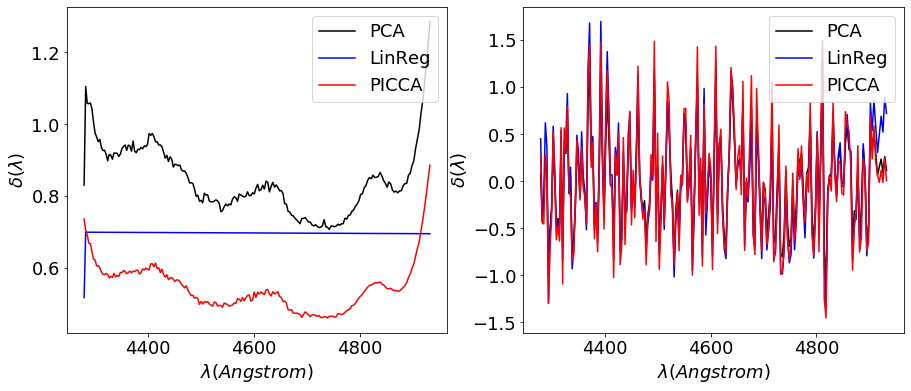

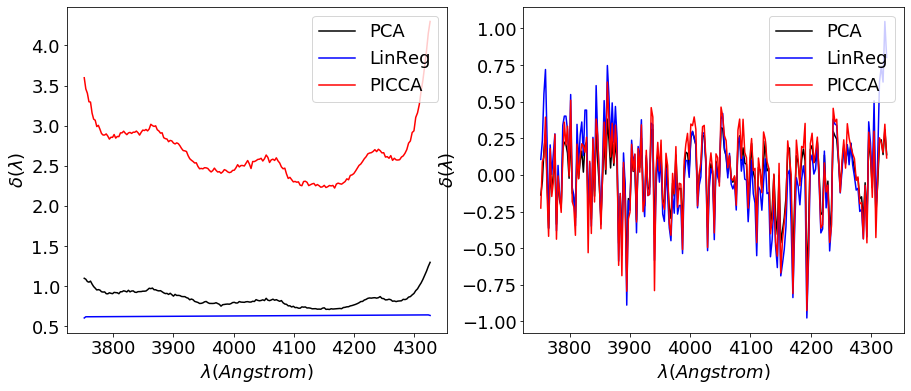

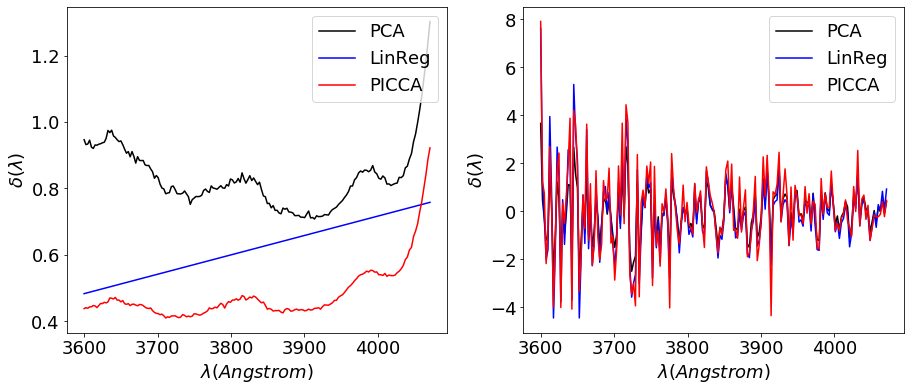

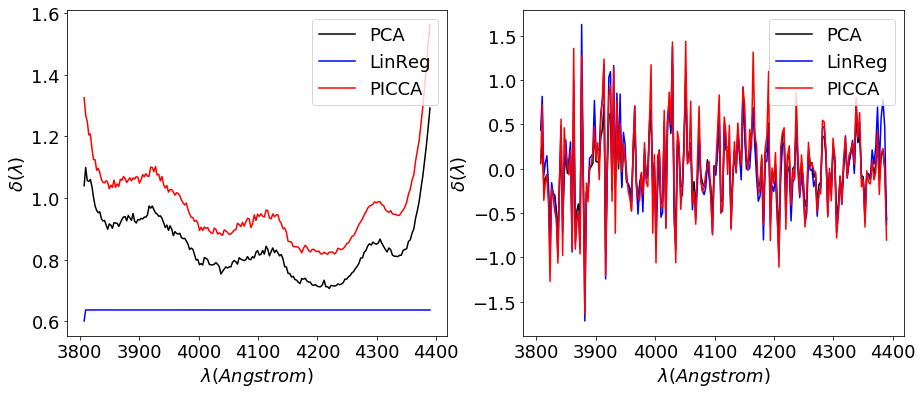

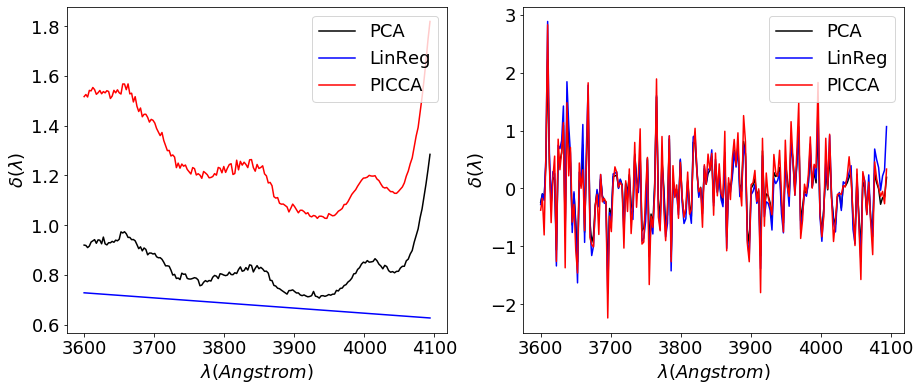

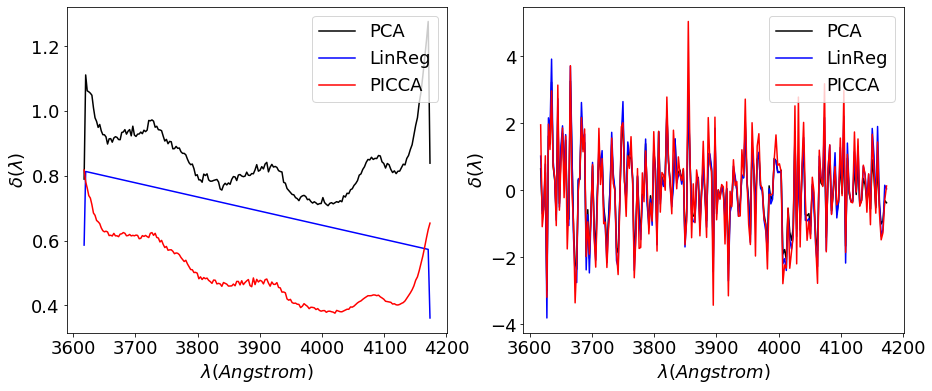

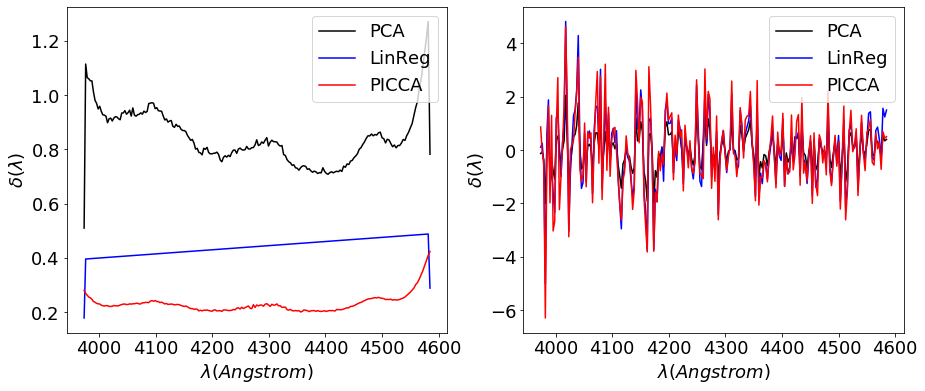

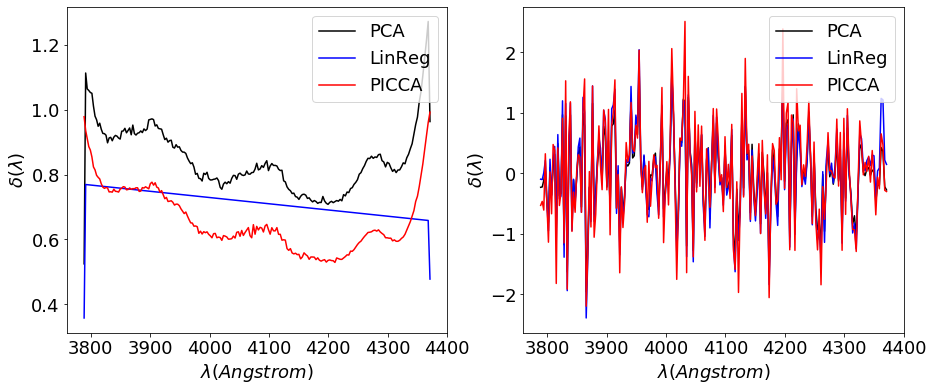

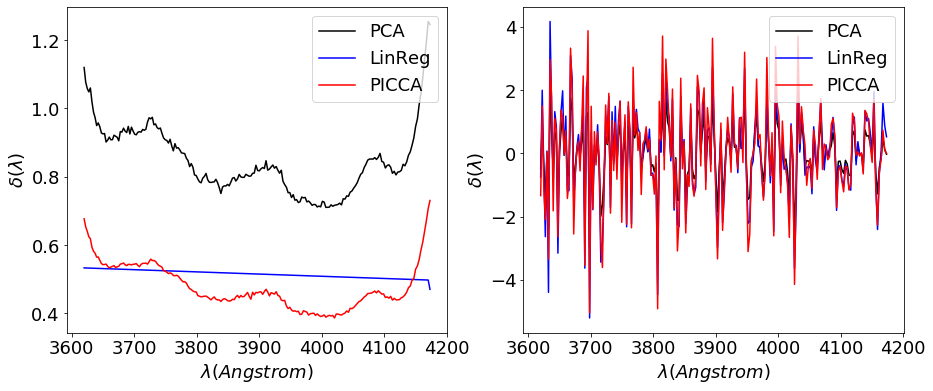

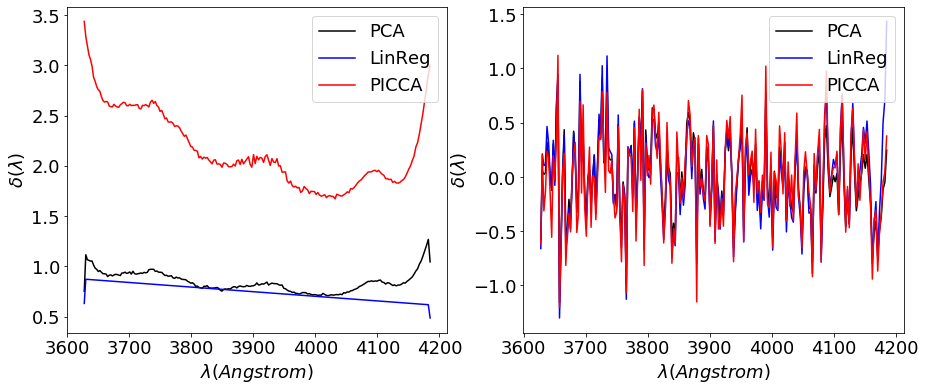

In [113]:

def compareDelta1(QSOloca, QSOlocb, spectraa1, spectraa2, spectrab):
   %matplotlib inline
   plt.rcParams["figure.figsize"] = (15, 6) # (w, h)
   plt.rcParams.update({'font.size': 18})
   # b for picca, a for Desi or eBoss
   a = np.array( QSOloca )
   b = np.array( QSOlocb )
   
   #print( len(spectraa1) )
   #print( len(spectraa2) )
   
   for i in range( 0, 10) :         # range( len(b) ):
      indx = np.where( a[:,3] == b[i][3] )
      
      #print( np.squeeze(indx) )
      indx = np.squeeze(indx)
      ###  a -- indx, b --- i
      wa1_, fluxa1_, ivara1_, conta1_ = spectraa1[ indx ]
      wa2_, fluxa2_, ivara2_, conta2_ = spectraa2[ indx ]
      wb_, fluxb_, ivarb_, contb_ = spectrab[ i ]
      
      if 1:         # Resample flux to picca wave
      # fluxa from wa to wb
         fluxa1_,ivara1_  = resample_flux( wb_, wa1_, fluxa1_, ivar=ivara1_ )   # continuum fo dwave grid
         fluxa2_,ivara2_  = resample_flux( wb_, wa2_, fluxa2_, ivar=ivara2_ )   # continuum fo dwave grid
         
         conta1_ = resample_flux( wb_, wa1_, conta1_ )   # continuum fo dwave grid
         conta2_ = resample_flux( wb_, wa2_, conta2_ )   # continuum fo dwave grid
               
      fig, ax = plt.subplots(1,2)
      ax[0].plot( wb_, conta1_*18.3, 'black', label='PCA' )
      ax[0].plot( wb_, conta2_*18.3, 'b', label='LinReg' )
      ax[0].plot( wb_, contb_, 'r', label='PICCA' )
      ax[0].legend( loc='upper right' )
      ax[0].set(xlabel='$\lambda (Angstrom)$')
      ax[0].set(ylabel='$\delta (\lambda)$')
      
      ax[1].plot( wb_, fluxa1_, 'black', label='PCA' )
      ax[1].plot( wb_, fluxa2_, 'b', label='LinReg' )
      ax[1].plot( wb_, fluxb_, 'r', label='PICCA' )
      ax[1].legend( loc='upper right' )
      ax[1].set(xlabel='$\lambda (Angstrom)$')
      ax[1].set(ylabel='$\delta (\lambda)$')
      #print( r"$\delta_{PICCA}$", wb_[0]-wb_[1], r"   $\delta_{Instrument}$", wa1_[0]-wa1_[1] )
      plt.show()


compareDelta1( QSOloc_Desi, QSOloc_Picca, deltas_Desi_PCA, deltas_Desi_linMin, deltas_Picca ) 






In [ ]:
l = np.linspace(1040., 1200., 1000)
alpha = .8
l2 = alpha*l-alpha*1080+1040
l3 = alpha*l

plt.plot(l,l3)
plt.plot(l,l2)
plt.plot(1160,1200., 'ro')
plt.plot(1080,1040., 'ro')
plt.plot(l,l*0+1040)
plt.plot(l,l*0+1200)
plt.grid()


In [ ]:
# QSOloc_eBoss, spectra_eBoss
# Healpix example

# OUTPUT function
#  z     = QSOloc[ i ][0]
#  dec   = QSOloc[ i ][1]
#  ra    = QSOloc[ i ][2]
#  id    = QSOloc[ i ][3]
#  w_    = spectra[ i ][ 0 ]
#  flux_ = spectra[ i ][ 1 ]
#  ivar_ = spectra[ i ][ 2 ]

a =  np.squeeze( np.array(QSOloc_Desi ) )
a = np.array(QSOloc_Desi)
#print( a[:][1] )
print( a.shape )

#print(a[0:4, 3])
#print(a[0:4, 2])
print('array: ', a[:,1])
#print('full: ', QSOloc_Desi)

#print( np.hstack( ( a[:,1],a[:,2] ) ) )

#print(  np.unique(a[:,4] ) )

nside = 8
nest = True


heal_pix = healpy.ang2pix(nside, sp.pi/2.-a[:,1], a[:,2], False)
print( np.unique(heal_pix) )

In [67]:
save = '/work/sfbeltranv/lyad_output/delta-145.fits.gz'
savep = '/work/sfbeltranv/output/deltas/delta-145.fits.gz'

a = Table.read(save)
print( a )
ap = Table.read(savep)
print( ap.colnames )

      LOGLAM       DELTA       WEIGHT               CONT        
   Log Angstrom                                                 
------------------ ----- ------------------ --------------------
3.0171072890157005   0.0  1.237464427947998  0.08868128486046072
3.0172179119289315   0.0 1.2664045095443726   0.0883202988938986
3.0173285066716167   0.0 1.3049883842468262  0.04968377527050792
3.0174390732580996   0.0 1.3310563564300537 0.039081414088400074
3.0175496117027136   0.0  1.334619164466858  0.09514101604909905
  3.01766012201978   0.0 1.4087363481521606 0.003167888385401393
3.0177706042236094   0.0 1.4660289287567139 0.011787730295722375
 3.017881058328503   0.0 1.3619184494018555  0.01293758746492591
3.0179914843487494  -0.0 1.3190844058990479 -0.09092097369903057
3.0181018822986267   0.0 1.4567811489105225  0.08073641902452963
               ...   ...                ...                  ...
 3.203425435814076   0.0  7.599884033203125  0.03712297870557554
3.2034974712583417   0.0 